# Setup

## Install libraries and download data to the machine

In [1]:
%%capture
!pip install pmdarima
!pip install --upgrade --no-cache-dir gdown

In [2]:
!gdown --id 19t92-s00cmz6BMoxj1IsxCywq_j9jEC0

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=19t92-s00cmz6BMoxj1IsxCywq_j9jEC0
To: /content/book-COINBASE-BTC-USD.csv
100% 282M/282M [00:15<00:00, 18.7MB/s]


## Import libraries and load data to the notebook

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import lag_plot
from pmdarima.arima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import ndiffs
from sklearn.metrics import mean_squared_error

from tqdm import tqdm
import pickle

In [4]:
BOOK_DATA_PATH = "book-COINBASE-BTC-USD.csv"
df_total = pd.read_csv(BOOK_DATA_PATH, index_col='timestamp', parse_dates=True).sort_index()
df_total = df_total[~df_total.index.duplicated(keep='first')]

# Endogenous version

## Data preparation

In [5]:
# midprice
kernel_size = 20
mid_price = (df_total['ap0'] + df_total['bp0']) / 2
m_minus = mid_price.rolling(kernel_size).mean()

m_minus = m_minus.dropna()[::kernel_size]
print("Time series shape:", m_minus.shape)
m_minus.head(3)

Time series shape: (34962,)


timestamp
2022-02-13 21:00:01.039    42462.27450
2022-02-13 21:00:02.067    42465.53825
2022-02-13 21:00:03.112    42462.39050
dtype: float64

In [ ]:
train_len = int(len(m_minus) * 0.8)
train, test = m_minus[:train_len], m_minus[train_len:]

## Data exploration

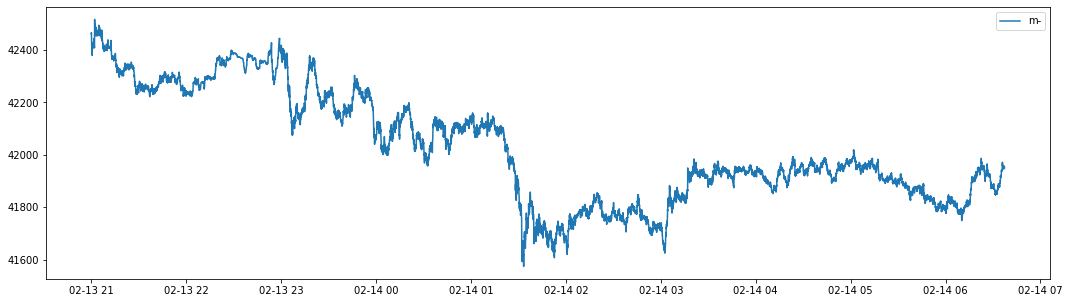

In [ ]:
plt.figure(figsize=(18, 5))
plt.plot(train, label='m-')
plt.legend()
plt.show()

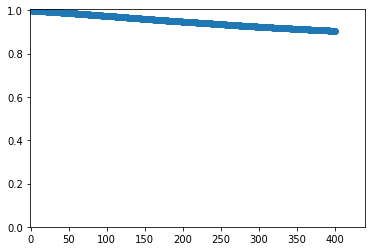

In [ ]:
train_centered = train.copy() - train.mean()
plt.acorr(train_centered, maxlags=400, usevlines=False)
plt.xlim(-1)
plt.ylim(0)
plt.show()

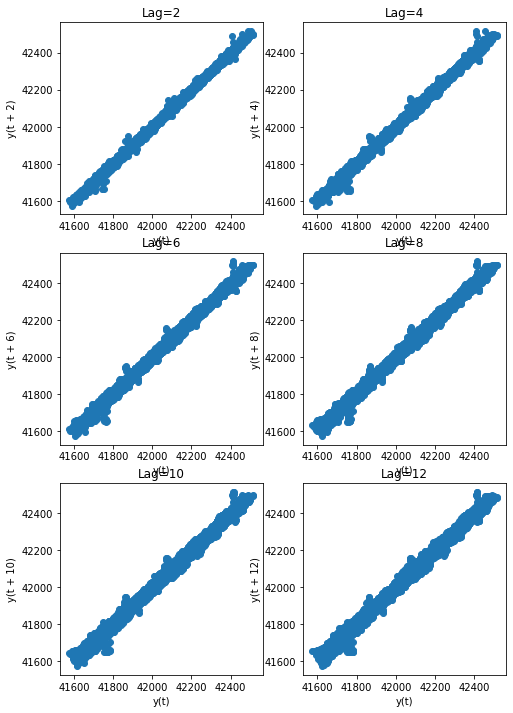

In [ ]:
fig, axes = plt.subplots(3, 2, figsize=(8, 12))

# The axis coordinates for the plots
ax_idcs = [
    (0, 0),
    (0, 1),
    (1, 0),
    (1, 1),
    (2, 0),
    (2, 1)
]

for lag, ax_coords in enumerate(ax_idcs, 1):
    lag *= 2
    ax_row, ax_col = ax_coords
    axis = axes[ax_row][ax_col]
    lag_plot(train, lag=lag, ax=axis)
    axis.set_title(f"Lag={lag}")

plt.show()

## ARIMA fitting

In [ ]:
kpss_diffs = ndiffs(train, alpha=0.05, test='kpss', max_d=6)
adf_diffs = ndiffs(train, alpha=0.05, test='adf', max_d=6)
n_diffs = max(adf_diffs, kpss_diffs)

print(f"Estimated differencing term: {n_diffs}")

Estimated differencing term: 1


In [ ]:
auto = auto_arima(train, d=n_diffs, seasonal=False, stepwise=True,
                  suppress_warnings=True, error_action="ignore",
                  max_order=None, trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=147439.270, Time=24.04 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=148979.803, Time=0.80 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=147545.704, Time=1.79 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=147439.410, Time=4.85 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=148978.570, Time=0.33 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=147435.194, Time=9.40 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=147439.489, Time=7.09 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=147439.414, Time=7.57 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=147435.658, Time=22.15 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=147441.028, Time=8.90 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=147440.604, Time=14.75 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=147427.607, Time=82.24 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=147414.909, Time=33.03 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=147427.564, Time=39.22 sec

In [ ]:
save_model = False

if save_model:
    with open('trained_arima.pickle', 'wb') as handle:
        pickle.dump(auto, handle)

## Testing

In [ ]:
test_small = test[:100]

In [ ]:
model = auto  # seeded from the model we've already fit

def forecast_one_step():
    fc = model.predict(n_periods=1)
    return fc.tolist()[0]

forecasts = []

for new_ob in tqdm(test_small):
    fc = forecast_one_step()
    forecasts.append(fc)

    # Updates the existing model with a small number of MLE steps
    model.update(new_ob)

print(f"\nMean squared error: {mean_squared_error(test_small, forecasts):.2f}")
print(f"Compare to standard deviation of test data: {np.std(test_small):.2f}")

100%|██████████| 100/100 [03:52<00:00,  2.32s/it]


Mean squared error: 5.95
Compare to standard deviation of test data: 4.44


# Model with exogeneous features

## Sanity check: supplying information from future as exogeneous features

In [6]:
X = mid_price.to_numpy()[:len(m_minus) * kernel_size].reshape(len(m_minus), 20)
print(X.shape)
assert np.allclose(m_minus.to_numpy(), X.mean(axis=1))

(34962, 20)


In [ ]:
X_train, X_test = X[:train_len], X[train_len:]

In [ ]:
auto = auto_arima(train, X=X_train, d=n_diffs, seasonal=False, stepwise=True,
                  suppress_warnings=True, error_action="ignore",
                  max_order=None, trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-592531.373, Time=73.33 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-592520.065, Time=49.90 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-592497.876, Time=52.13 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-592537.039, Time=65.32 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-592522.065, Time=47.53 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=nan, Time=142.41 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-592535.264, Time=68.42 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-592532.849, Time=72.75 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-592539.039, Time=65.98 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=nan, Time=140.06 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-592537.264, Time=66.50 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-592499.876, Time=49.84 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-592534.849, Time=67.29 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time

In [ ]:
X_test_small = X_test[:100]
model = auto  # seeded from the model we've already fit

forecasts = model.predict(n_periods=len(test_small), X=X_test_small).tolist()

print(f"\nMean squared error: {mean_squared_error(test_small, forecasts):.3f}")
print(f"Compare to standard deviation of test data: {np.std(test_small):.3f}")


Mean squared error: 0.000
Compare to standard deviation of test data: 4.438


## Previous midprices as exogenuos features

In [7]:
m_minus = m_minus[1:]
X = X[:-1]

In [8]:
train_len = int(len(m_minus) * 0.8)
train, test = m_minus[:train_len], m_minus[train_len:]
X_train, X_test = X[:train_len], X[train_len:]

test_small = test[:30]
X_test_small = X_test[:30]

In [34]:
tune_hyperparams = False

if tune_hyperparams:
    auto = auto_arima(train, X=X_train, d=n_diffs, seasonal=False, stepwise=True,
                    suppress_warnings=True, error_action="ignore",
                    max_order=None, trace=True)
else:
    order = (0,1,1)
    auto = ARIMA(train.to_numpy(), exog=X_train, order=order)
    res = auto.fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


In [35]:
from copy import copy, deepcopy
res_copy = deepcopy(res)

In [40]:
test = test.to_numpy()

forecasts = []

for i in tqdm(range(len(test))):
    new_ob = test[i:i+1]

    fc = res.forecast(exog=X_test[i:i+1])
    forecasts.append(fc.tolist()[0])

    res = res.extend(new_ob, exog=X_test[i:i+1])  #, refit=False
    # model.update(new_ob, X=X_test_small[i:i+1])

print(f"\nMean squared error: {mean_squared_error(test, forecasts):.2f}")
print(f"Compare to standard deviation of test data: {np.std(test):.2f}")

100%|██████████| 6993/6993 [00:53<00:00, 130.43it/s]


Mean squared error: 7.77
Compare to standard deviation of test data: 120.78
